In [1]:
from GT import get_dataset
import matplotlib.pyplot as plt
from GT import ASGGTM
import json
import torch
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tsl.datasets.mts_benchmarks import ExchangeBenchmark
from Notebooks.Eval.VisualEval import visualization, plot_boxplots_means, plot_histograms_means


DATASET_NAME = 'ExchangeBenchmark'
MODEL_NAME= 'ASGGTMExchangeBenchmark'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 8
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0.1
bidirectional = True
mixture_dim = 36
train_from_checkpoint = False

dataset = ExchangeBenchmark()

max_size = 7560

exo = dataset.datetime_encoded('day').values

dataset = dataset.dataframe()[:7560]
exo = exo[:7560]

In [4]:
def datetime_encoded(index, units) -> pd.DataFrame:
        r"""Transform dataset's temporal index into covariates using sinusoidal
        transformations. Each temporal unit is used as period to compute the
        operations, obtaining two feature (:math:`\sin` and :math:`\cos`) for
        each unit."""
        units = [units]
        index_nano = index.view(np.int64)
        datetime = dict()
        for unit in units:
            nano_unit = pd.Timedelta('1' + unit).value
            nano_sec = index_nano * (2 * np.pi / nano_unit)
            datetime[unit + '_sin'] = np.sin(nano_sec)
            datetime[unit + '_cos'] = np.cos(nano_sec)
        return pd.DataFrame(datetime, index=index, dtype=np.float32)

## Dataset

In [5]:
# Dataset Split\
Train, Validation, Test = get_dataset('ExchangeBenchmark', dataset, 216)

# Train[..., 0] = Train[..., 5]

train_data = Train
train_data = torch.Tensor(train_data)
exo_var = torch.Tensor(exo).reshape(train_data.shape[0], train_data.shape[1], 2)
# exo_var = []
input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)
exo_size = 2

emb_size = 4
# exo_var = (exo_var - exo_var.min()) / (exo_var.max() - exo_var.min())  

ExchangeBenchmark DATA
Original Dataset: 	105
Train Split: 		35 	(70%)
Validation Split: 	35 	(20%)
Test Split: 		35 	(10%)


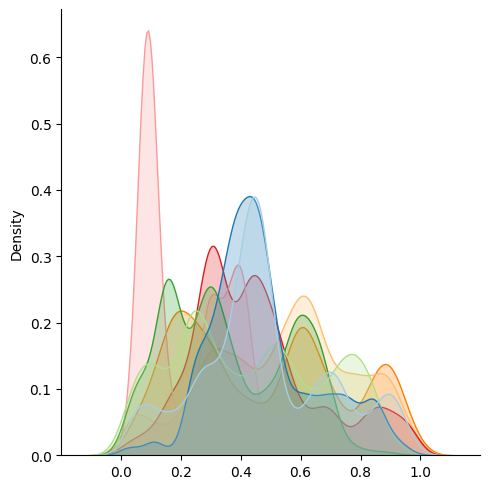

In [6]:
sns.displot(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), fill=True, kind='kde', palette='Paired', legend=False)
plt.show()

## Model Train

In [7]:
# Model Train
model = ASGGTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, emb_size, exo_size)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, emb_size, exo_size
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, exo_var, batch_size=7, window=20, horizon=1, epochs=10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_76435/218354081.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

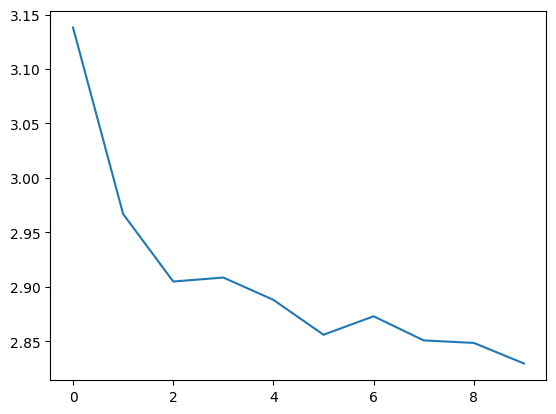

<Figure size 640x480 with 0 Axes>

In [8]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

# Model Eval


In [9]:
exo_var = pd.date_range(dataset.index.max() + pd.Timedelta(1, 'day'), freq='D', periods=11800)
exo_var = torch.tensor(datetime_encoded(exo_var, 'day').values).reshape(50, 236, 2)
exo_var.shape

torch.Size([50, 236, 2])

In [10]:
output = model.generate_step(shape=(50, 216, 8), exo_var=exo_var, window = 20, horizon=1)
prediction = model.predict_step(data=train_data[0:10], exo_var=exo_var[:10], steps=216, window=20)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
  0%|          | 0/216 [00:00<?, ?it/s]/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

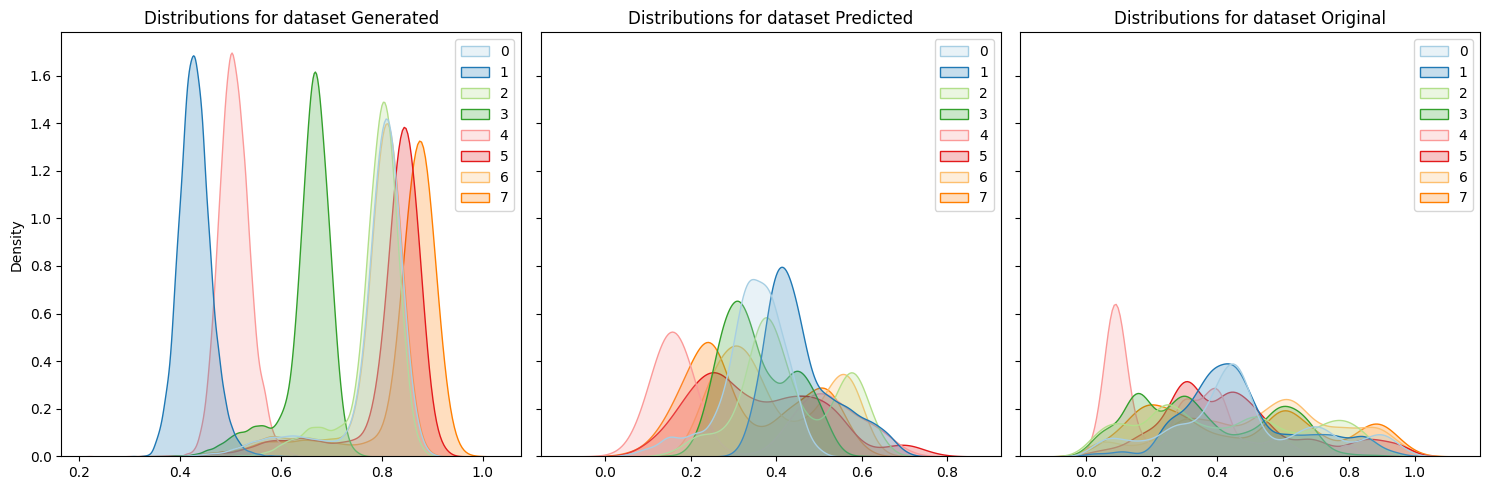

In [11]:
def plot_dist(datasets, kind='kde'):
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True, sharex=False)
    if kind == 'box':
        plot_ = sns.boxplot
    elif kind == 'ecdf':
        plot_ = sns.ecdfplot
    elif kind == 'kde':
        plot_ = sns.kdeplot
    else:
        plot_ = sns.histplot

    reshaped_output = {}
    for key, gen in datasets.items():
        # Reshape the data to combine samples and time steps (flatten them)
        reshaped_output[key] = gen.reshape(gen.shape[0] * gen.shape[1], gen.shape[2])
        
    # Plot KDE for each feature (assuming output has 3 features)
    for i, item in zip(range(0, len(reshaped_output)), reshaped_output.items()):
        k, data = item
        if kind == 'kde':
            plot_(data, ax=ax[i], palette='Paired', fill=True, legend='auto')
        else:
            plot_(data, ax=ax[i], palette='Paired')
        ax[i].set_title(f'Distributions for dataset {k}')

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_dist({'Generated': output, 'Predicted': prediction, 'Original': train_data}, 'kde')

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_76435/2603738427.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1), label='True')
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_76435/2603738427.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

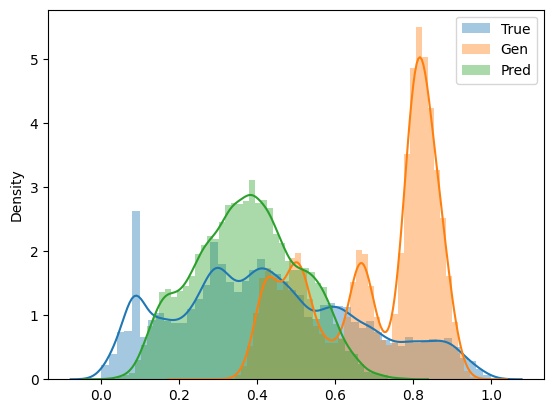

In [12]:
sns.distplot(train_data.reshape(train_data.shape[0]*train_data.shape[1], -1), label='True')
sns.distplot(output.reshape(output.shape[0]*output.shape[1], -1), label='Gen')
sns.distplot(prediction.reshape(prediction.shape[0]*prediction.shape[1], -1), label='Pred')
plt.legend()
plt.show()

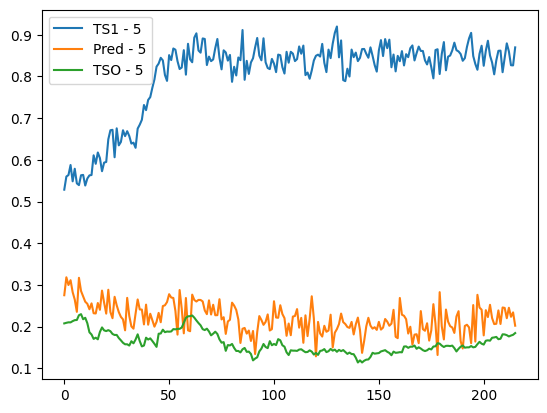

In [13]:
plt.plot(output[3, :, 5], label='TS1 - 5') 

plt.plot(prediction[1, :, 5], label='Pred - 5')

plt.plot(train_data[1, :, 5], label='TSO - 5')
plt.legend()
plt.show()

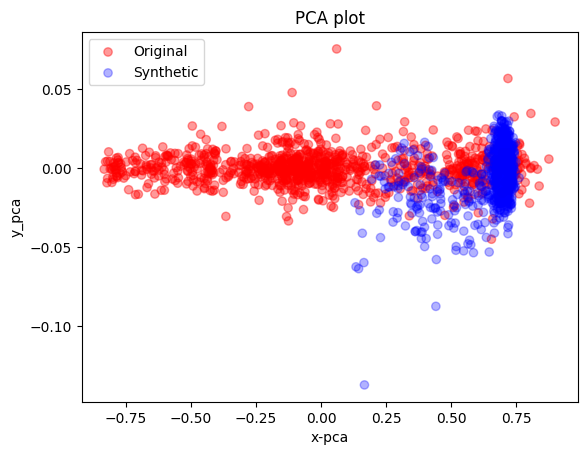

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.011296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.991959
[t-SNE] KL divergence after 300 iterations: 1.169036


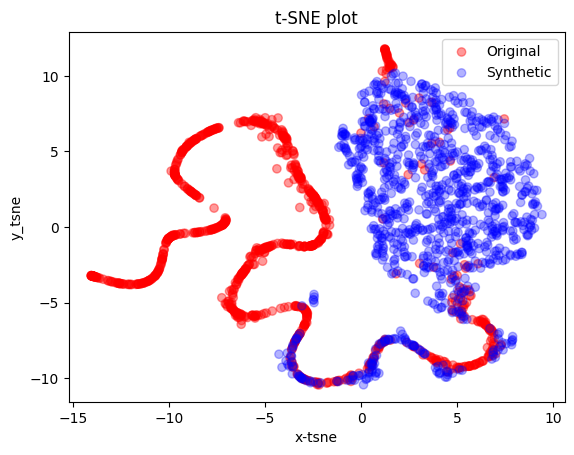

In [14]:
mlen = train_data.shape[0]*train_data.shape[1] // 6
olen =  output.shape[0]*output.shape[1] // 6
visualization(train_data.reshape(mlen, 6, 8)[:olen], torch.Tensor(output).reshape(olen, 6, 8), 'pca')
visualization(train_data.reshape(mlen, 6, 8)[:olen], torch.Tensor(output).reshape(olen, 6, 8), 'tsne')

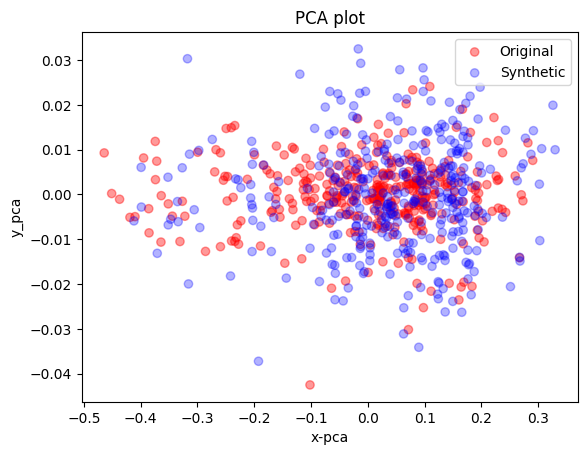

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 720 samples in 0.000s...
[t-SNE] Computed neighbors for 720 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 720 / 720
[t-SNE] Mean sigma: 0.014086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.347488
[t-SNE] KL divergence after 300 iterations: 0.556348


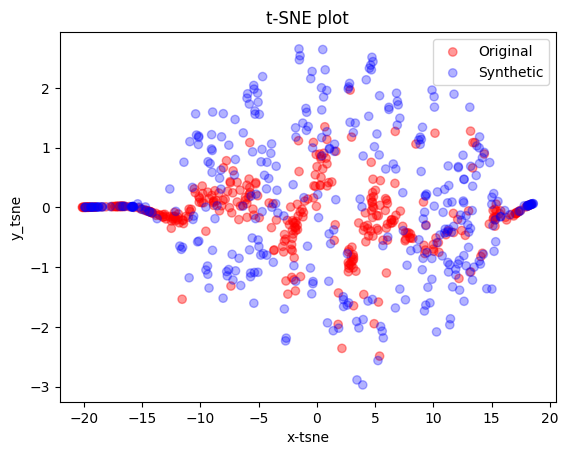

In [15]:
plen = prediction.shape[0]*output.shape[1] // 6
visualization(train_data.reshape(mlen, 6, 8)[:plen], torch.Tensor(prediction).reshape(plen, 6, 8), 'pca')
visualization(train_data.reshape(mlen, 6, 8)[:plen], torch.Tensor(prediction).reshape(plen, 6, 8), 'tsne')

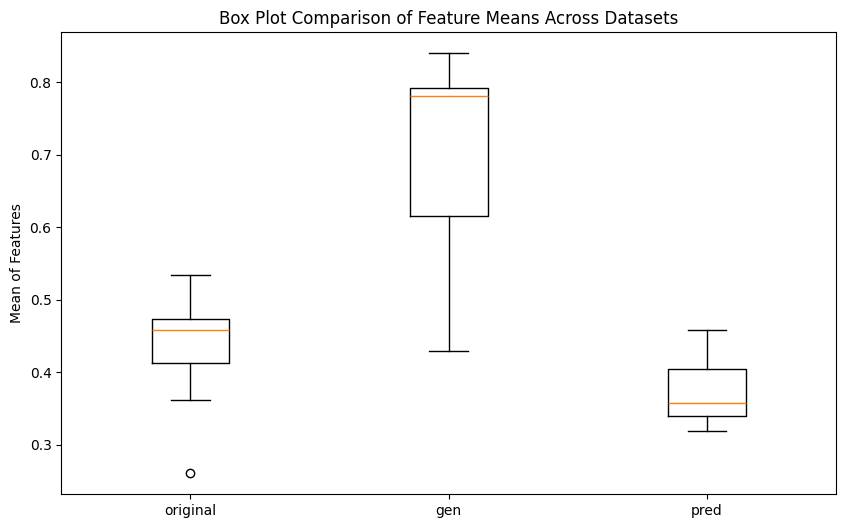

In [16]:
plot_boxplots_means(('original', np.array(train_data.reshape(mlen*6, 8))), ('gen', output.reshape(olen*6, 8)), ('pred', prediction.reshape(plen*6, 8)))